In [1]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import sc_data_folder, results_folder, today, color

In [2]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [3]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/rna_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Assessing extent of guide overassignment issue </h3>

In [144]:
#load raw anndata object
adata = sc.read_h5ad('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230113_all_cells.h5ad')

In [145]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata.var_names[~adata.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [146]:
# Create a list of expected guides including the control guides 
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

[i for i in expected_guides if i not in targeted_tf]

['sgRNA1_SCP', 'sgRNA6_SCP', 'ONE_INTERGENIC_SITE_1194']

In [174]:
#save counts in adata counts layer
adata.layers['counts'] = adata.X.copy()
#filter adata for cells with total_counts > 5000
adata_filtered = adata[adata.obs['total_counts'] > 5000].copy()

In [175]:
#filter adata_filtered for expected tf with regex
adata_filtered = adata_filtered[:, adata_filtered.var_names.str.contains('|'.join(expected_guides))].copy()

In [176]:
#normalize adata_filtered with scanpy
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
#create log transformed layer
adata_filtered.layers["log_transformed"] = np.log1p(adata_filtered.X)


In [34]:
#create function to convert adata X (sparse marix) to convert to 2d array
def sparse_to_2d_arr(adata):

    #convert sparse matrix to dense matrix
    dense_count_mtx=adata.X.todense()
    print(dense_count_mtx)
    #convert matrix into 2d array
    dense_count_2d_arr=np.array(dense_count_mtx)
    #convert 2d array to dtype int
    dense_count_2d_arr=dense_count_2d_arr.astype(int)

    return dense_count_2d_arr

In [35]:
#Create a function to count the number of times each value occurs in each row
def count_guide_frequency(dense_count_2d_arr):

        
    m = dense_count_2d_arr.shape[0]    
    n = dense_count_2d_arr.max()+1
    count_frequncy_arr = np.zeros((dense_count_2d_arr.max()+1,dense_count_2d_arr.shape[1]))

    for x in range(dense_count_2d_arr.shape[1]):
        bin_count_arr = np.bincount(dense_count_2d_arr[:,x])
        

        #create zero array to add to bin_count_arr to make the length of the array equal to the max value in dense_count_2d_arr
        n_filler = n-len(bin_count_arr)
        zero_filler = np.zeros(n_filler)
        full_bin_count_arr = np.concatenate((bin_count_arr,zero_filler))
        count_frequncy_arr[:,x] = full_bin_count_arr 
        

    return count_frequncy_arr #exclude first column as it only consists of zeros

In [36]:
dense_count_2d_arr = sparse_to_2d_arr(adata_filtered)
guide_frequency = count_guide_frequency(dense_count_2d_arr)

[[0.00000000e+00 0.00000000e+00 5.42815674e+03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.26742706e+01 6.33713531e+00]
 [5.44378662e+02 7.10059128e+01 1.18343191e+01 ... 0.00000000e+00
  0.00000000e+00 1.18343191e+01]
 ...
 [0.00000000e+00 0.00000000e+00 1.54798765e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.68054295e+00 ... 0.00000000e+00
  0.00000000e+00 2.90416279e+01]
 [0.00000000e+00 2.45820999e+00 2.45820999e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


<h3> 1.1. guide UMI count distribution </h3>

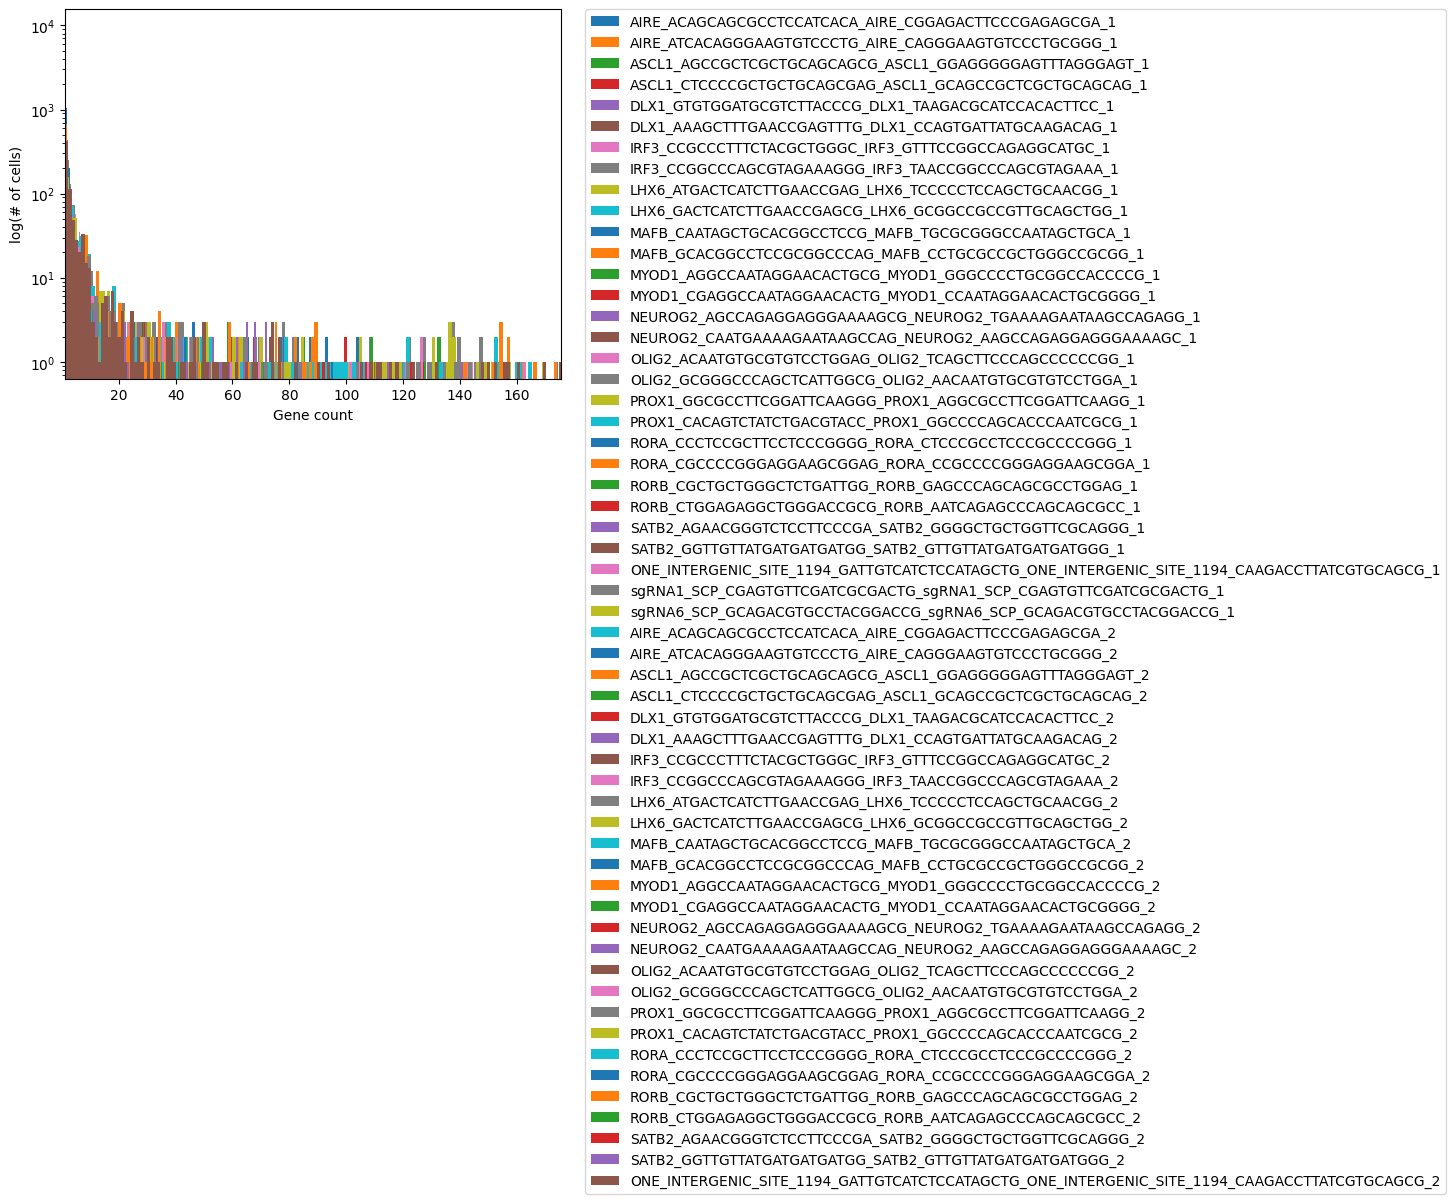

In [50]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Gene count')
    
    plt.ylabel('log(# of cells)')
    
    #plot adata.var_names for each gene as legend
    plt.legend(adata_filtered.var_names,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    #set lower xlim to 1, to exclude zero values
    plt.gca().set_xlim(left=1)

    #log scale y axis
    plt.gca().set_yscale('log')

    # plt.savefig(os.path.join(figures_folder,'gene_count_frequency_{}.png'.format(x)))
    # plt.close()

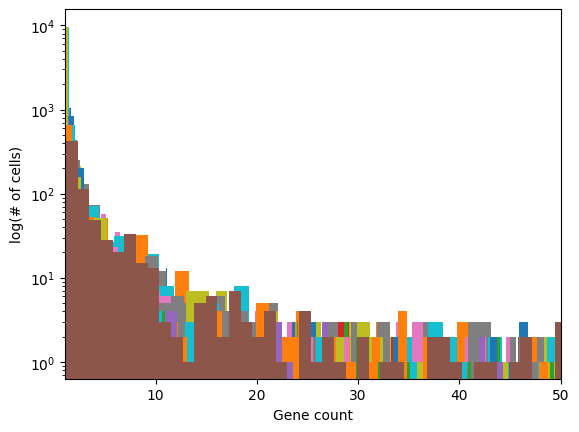

In [42]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Gene count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,50])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    #plt.gca().set_xlim(left=1)
    #plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_1_50.pdf',bbox_inches='tight')

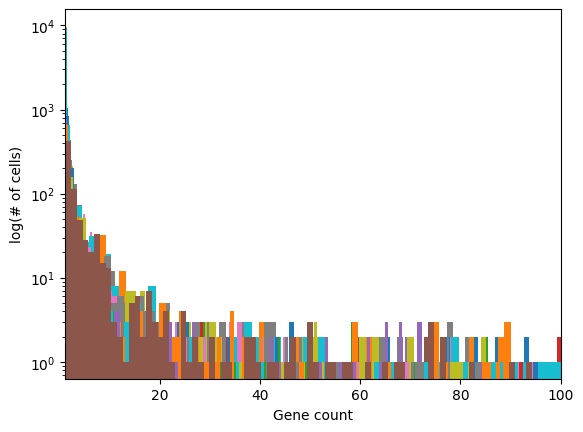

In [47]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Gene count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,100])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    # plt.gca().set_xlim(left=1)
    # plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_10_100.pdf',bbox_inches='tight')

<h3> 1.2. Guide fraction</h3>

In [52]:
#compute fraction per column to determine guide fraction of each cell 
guide_frac_per_cell=dense_count_2d_arr.T/dense_count_2d_arr.sum(axis=1)
guide_frac_per_cell=guide_frac_per_cell.T
#sort fraction in ascending order for each row
guide_frac_per_cell.sort(axis=0)
#remove all zeros in a column 
guide_frac_per_cell=guide_frac_per_cell[~np.all(guide_frac_per_cell == 0, axis = 1),:]

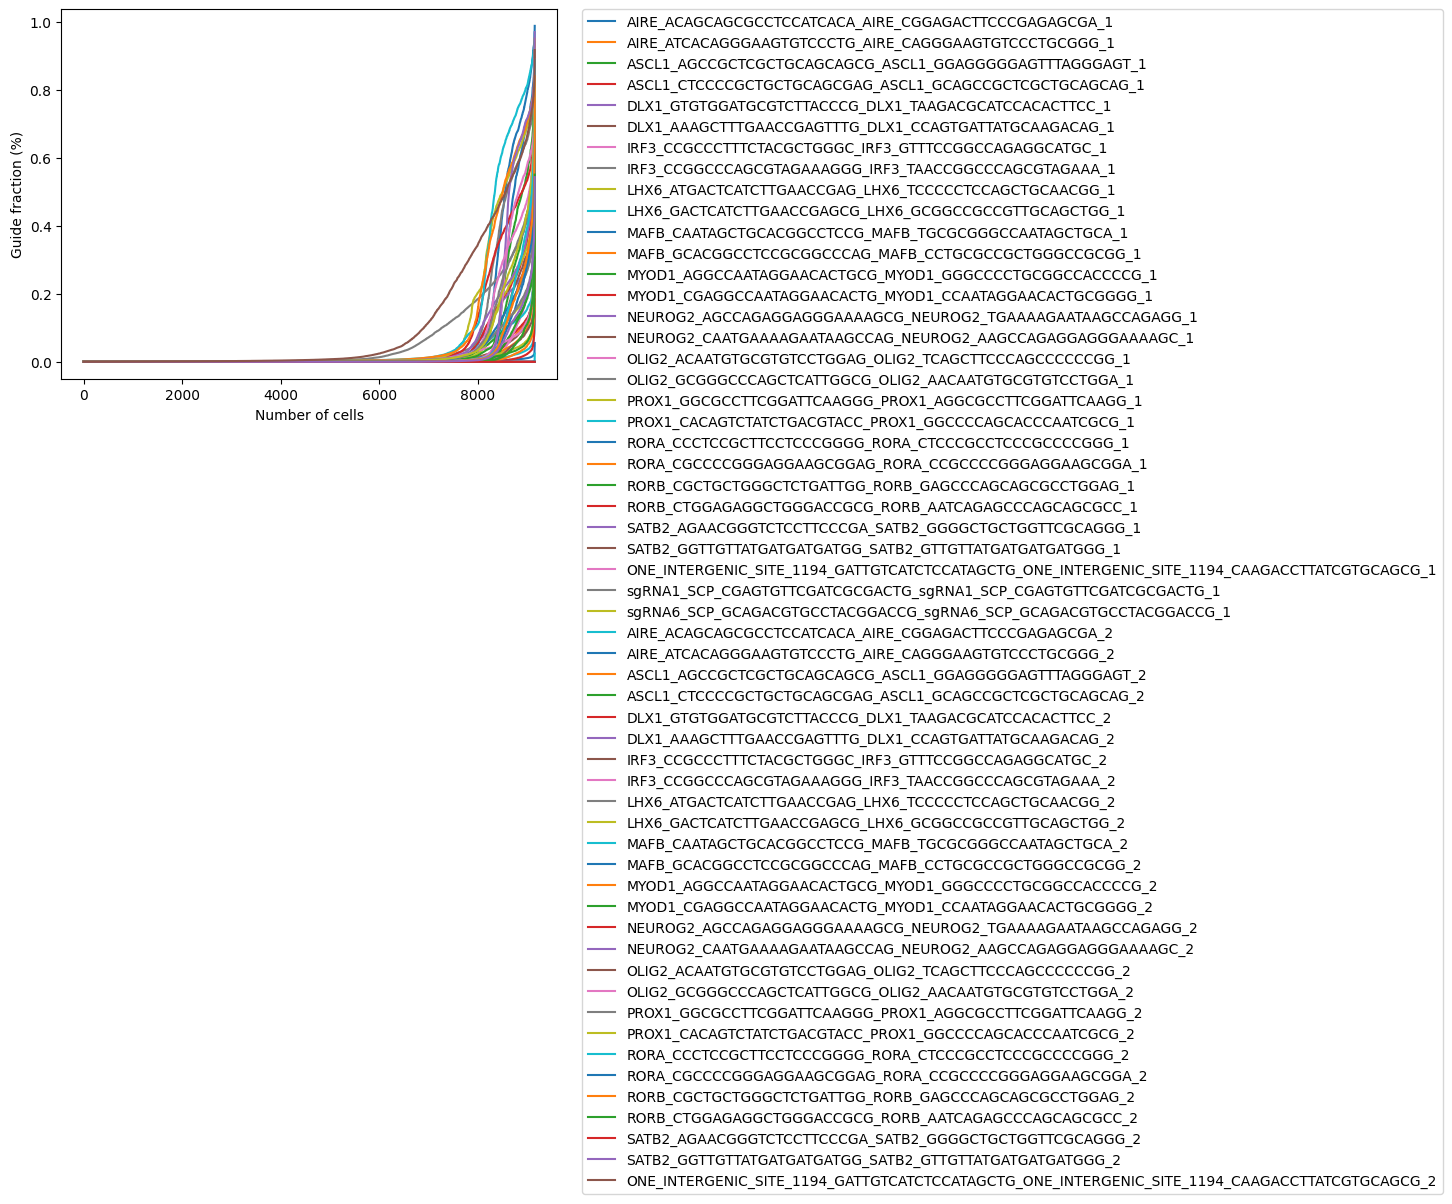

In [41]:
for x in range(0,guide_frequency.shape[1]):
    
    plt.plot(guide_frac_per_cell[:,x])

    plt.xlabel('Number of cells')
    
    plt.ylabel('Guide fraction (%)')
    
    #plot adata.var_names for each gene as legend
    plt.legend(adata_filtered.var_names,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    #plt.savefig(f'{figures_folder}{today}_tf_fraction_per_cell.pdf',bbox_inches='tight')
    

In [168]:
#assign pools based on experimental design
adata_filtered.var['guide_pool'] = adata_filtered.var_names.str.split('_').str[0]
#assign control guides to control pool
adata_filtered.var.loc[adata_filtered.var['guide_pool'].isin(['sgRNA1', 'sgRNA6', 'ONE']), 'guide_pool'] = 'control'

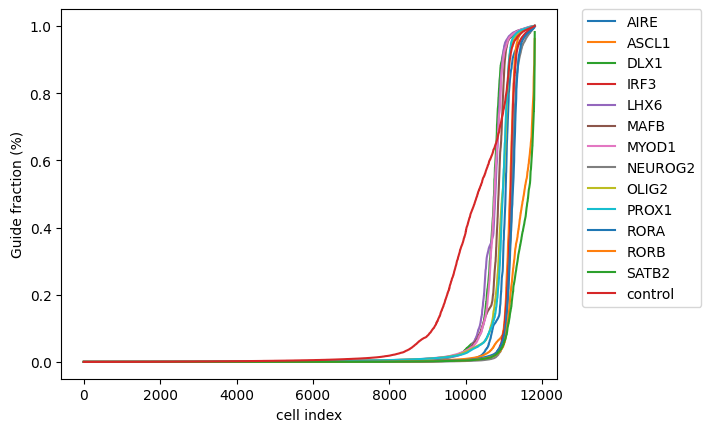

In [169]:
guide_pool_list = []
#calculate fraction of each guide pool
for pool in adata_filtered.var['guide_pool'].unique():

    #calculate fraction of each guide pool    
    idx = np.where(adata_filtered.var['guide_pool'] == pool)[0]
    tmp_frac = dense_count_2d_arr[:,idx].sum(axis=1)/dense_count_2d_arr.sum(axis=1)
    guide_pool_list.append(tmp_frac)
    tmp_frac.sort(axis=0)
    
    plt.plot(tmp_frac)
    #plot legend with short_name
    plt.legend(adata_filtered.var['guide_pool'].unique(),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('cell index')
    
    plt.ylabel('Guide fraction (%)')
    
    

AIRE
(11814, 2)
1
(11814, 2)
2
ASCL1
(11814, 2)
1
(11814, 2)
2
DLX1
(11814, 2)
1
(11814, 2)
2
IRF3
(11814, 2)
1
(11814, 2)
2
LHX6
(11814, 2)
1
(11814, 2)
2
MAFB
(11814, 2)
1
(11814, 2)
2
MYOD1
(11814, 2)
1
(11814, 2)
2
NEUROG2
(11814, 2)
1
(11814, 2)
2
OLIG2
(11814, 2)
1
(11814, 2)
2
PROX1
(11814, 2)
1
(11814, 2)
2
RORA
(11814, 2)
1
(11814, 2)
2
RORB
(11814, 2)
1
(11814, 2)
2
SATB2
(11814, 2)
1
(11814, 2)
2
sgRNA1_SCP
sgRNA6_SCP
ONE_INTERGENIC_SITE_1194


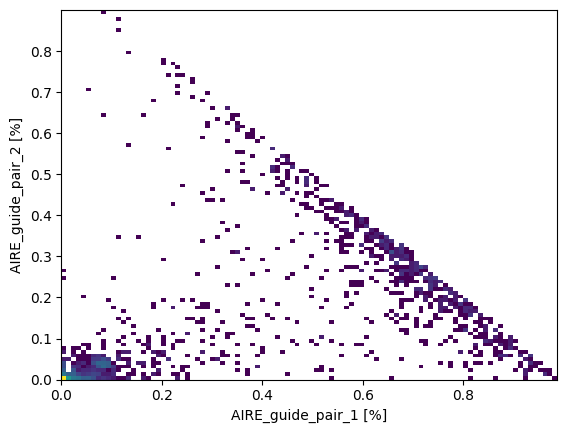

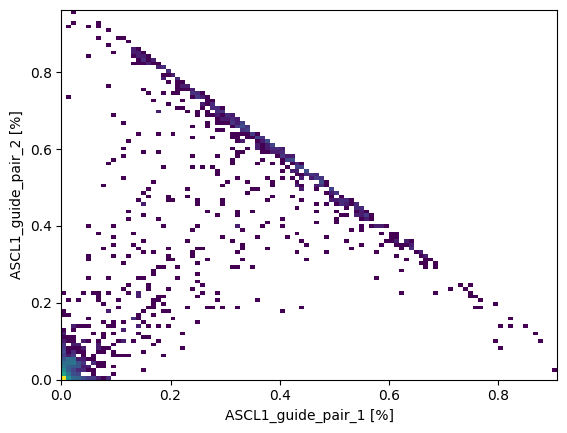

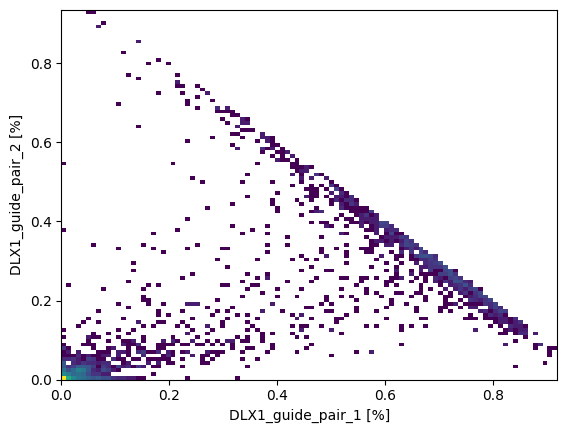

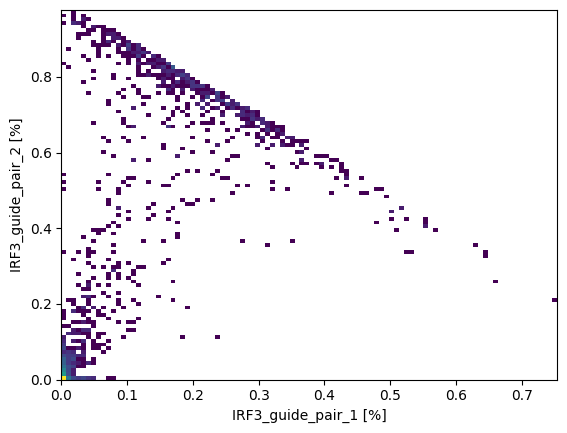

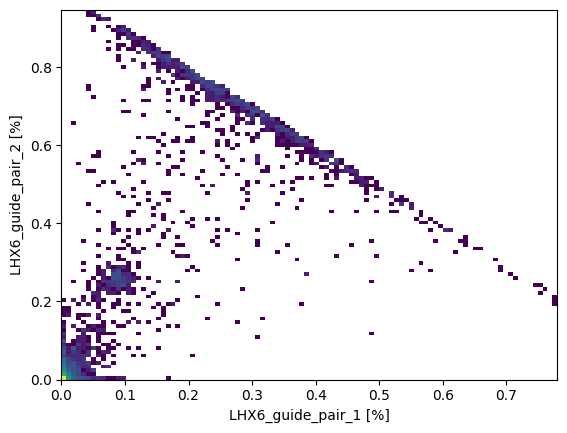

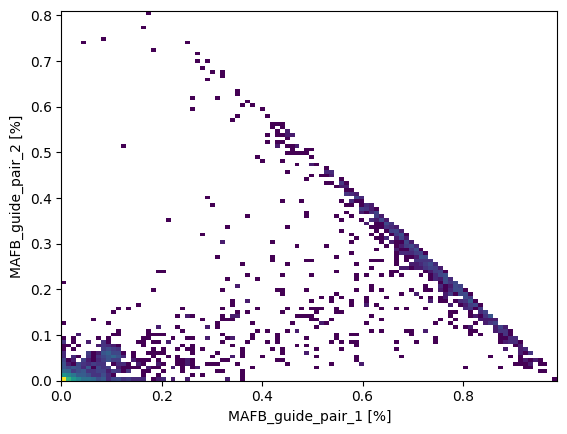

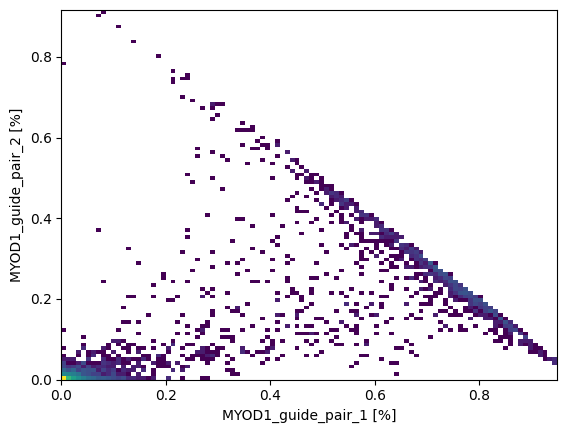

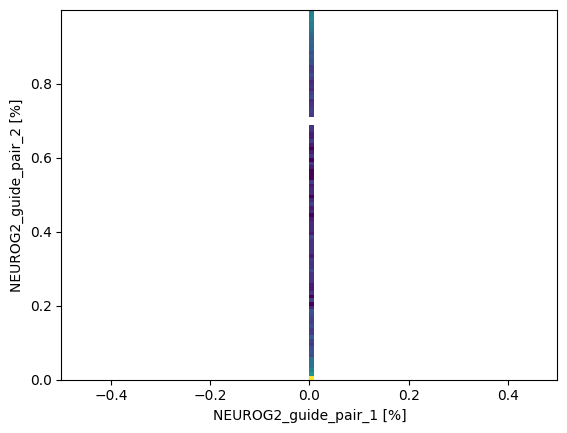

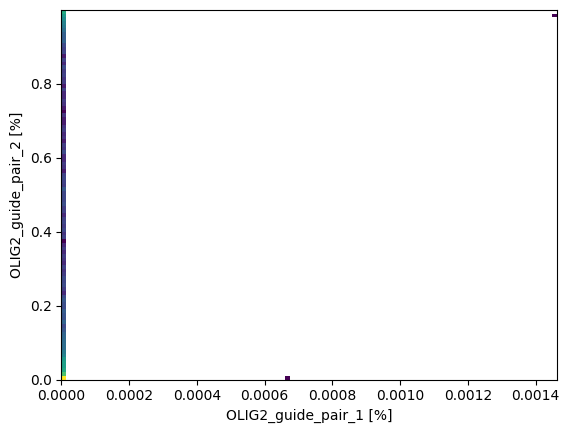

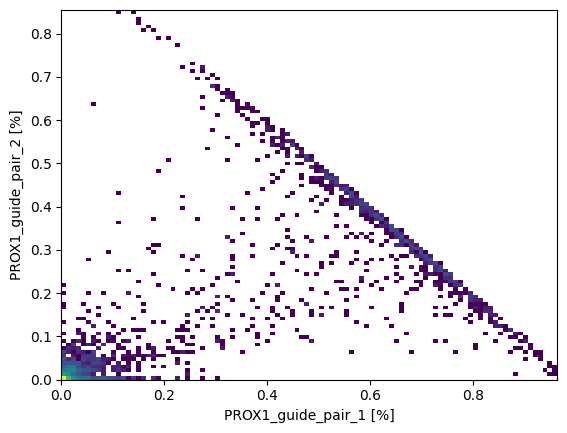

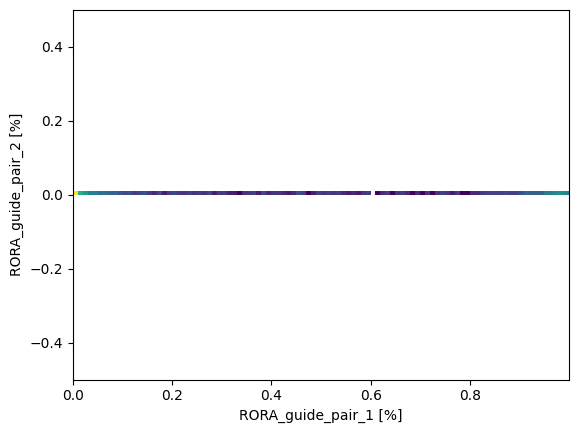

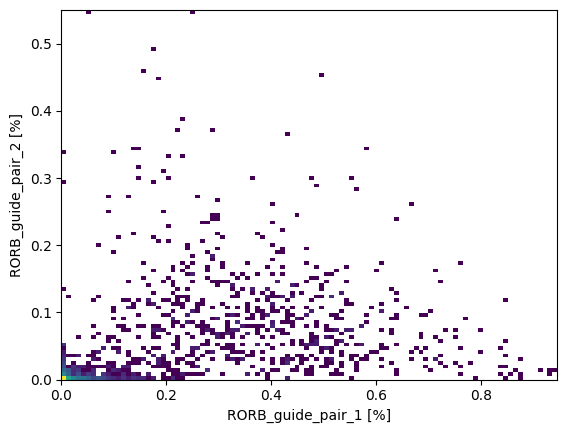

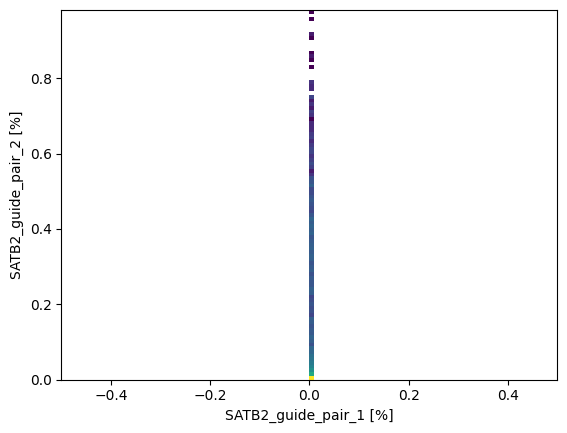

In [178]:
guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for short_name in expected_guides:
    print(short_name)
    tmp_guides = guides[guides.str.contains(short_name)]



    
    if len(tmp_guides) == 2:
        #create empty list to store fraction of each guide pair
        curr_guide_pool = []
        fig,axs = plt.subplots()
            
        for i,guide_name in enumerate(tmp_guides):
            tmp_adata=adata_filtered[:,adata_filtered.var_names.str.contains(guide_name)]
            print(tmp_adata.X.shape)
            #calculate fraction of each guide pair
            tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
            curr_guide_pool.append(tmp_frac)
            print(len(curr_guide_pool))
            
        #concatenate all fractions of each guide pair
        curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
        #convert to numpy array
        curr_guide_pool = np.array(curr_guide_pool)
        
        
        #plot scatter plot of guide pair fraction
        
        plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                        norm = colors.LogNorm())
        #add x and y label
        plt.xlabel(f'{short_name}_guide_pair_1 [%]')
        plt.ylabel(f'{short_name}_guide_pair_2 [%]')

Text(174.22222222222229, 0.5, 'gRNA')

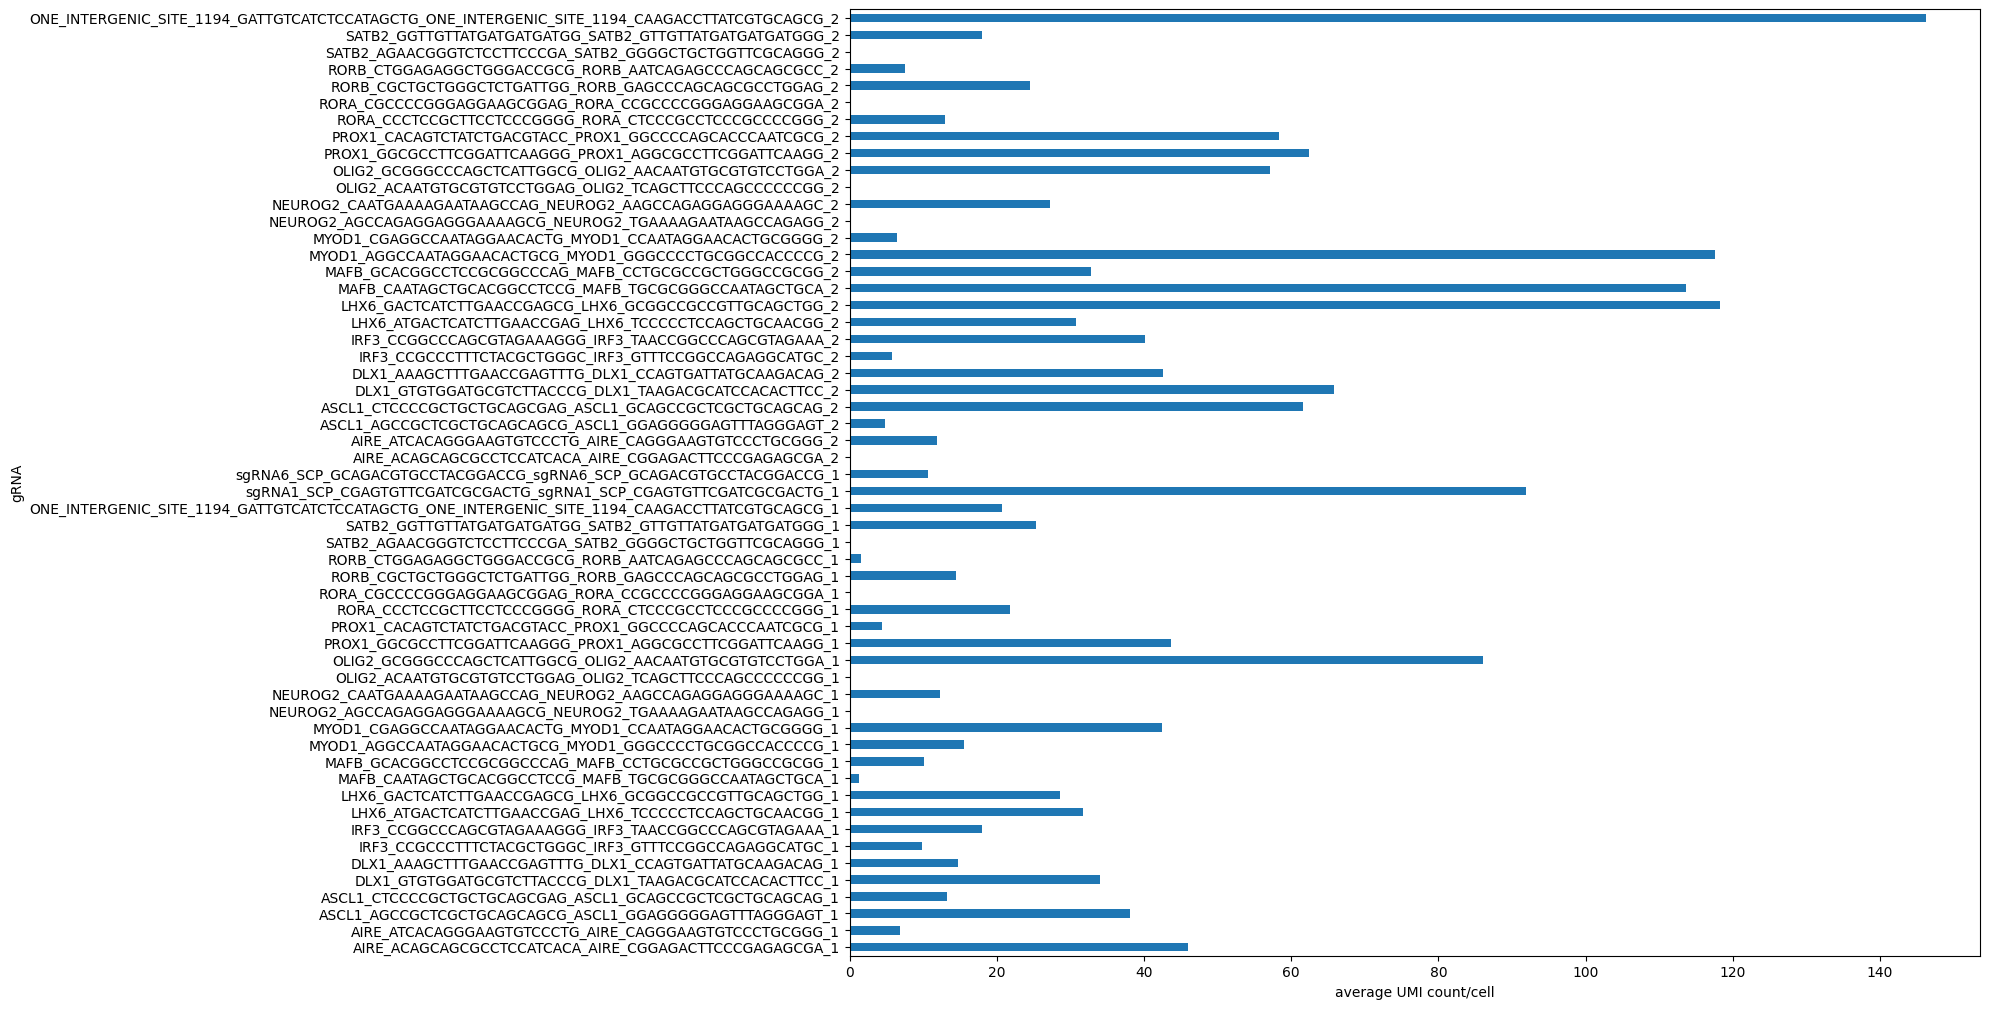

In [34]:
#plot barplot from pandas Series
tf_guides_series = pd.Series(
    np.array(adata_filtered.layers['counts'].mean(0)).flatten(),
    index=adata_filtered.var_names
)
fig, ax = plt.subplots()
tf_guides_series.plot.barh(
    figsize=(20,10)
    )
fig.subplots_adjust(left=0.5)
#adjust y axis to avoid overlap of text
ax.set_yticks(np.arange(len(tf_guides_series)))
fig.tight_layout()
#label x and y axis
plt.xlabel('average UMI count/cell')
plt.ylabel('gRNA')


# plt.savefig(f'{figures_folder}{today}_tf_guides_barplot.pdf',bbox_inches='tight')

0
[[  0.        0.     ]
 [  0.        0.     ]
 [544.37866   0.     ]
 ...
 [  0.        0.     ]
 [  0.        0.     ]
 [  0.        0.     ]]
1
[[  0.        14.513788]
 [  0.         0.      ]
 [ 71.00591  153.84616 ]
 ...
 [  0.         0.      ]
 [  0.         0.      ]
 [  2.45821    0.      ]]
0
[[5.42815674e+03 2.03193039e+02]
 [0.00000000e+00 0.00000000e+00]
 [1.18343191e+01 0.00000000e+00]
 ...
 [1.54798765e+01 0.00000000e+00]
 [9.68054295e+00 0.00000000e+00]
 [2.45820999e+00 0.00000000e+00]]
1
[[ 856.3135    3309.1438   ]
 [   0.           6.3371353]
 [   0.           0.       ]
 ...
 [   0.          46.439632 ]
 [   0.           9.680543 ]
 [   0.           0.       ]]
0
[[   0.           0.       ]
 [ 798.47906   1153.3586   ]
 [  11.834319    11.834319 ]
 ...
 [  15.4798765    0.       ]
 [   9.680543     0.       ]
 [   0.           0.       ]]
1
[[  0.          0.       ]
 [ 76.04562   551.33075  ]
 [  0.          0.       ]
 ...
 [ 15.4798765   0.       ]
 [  0.     

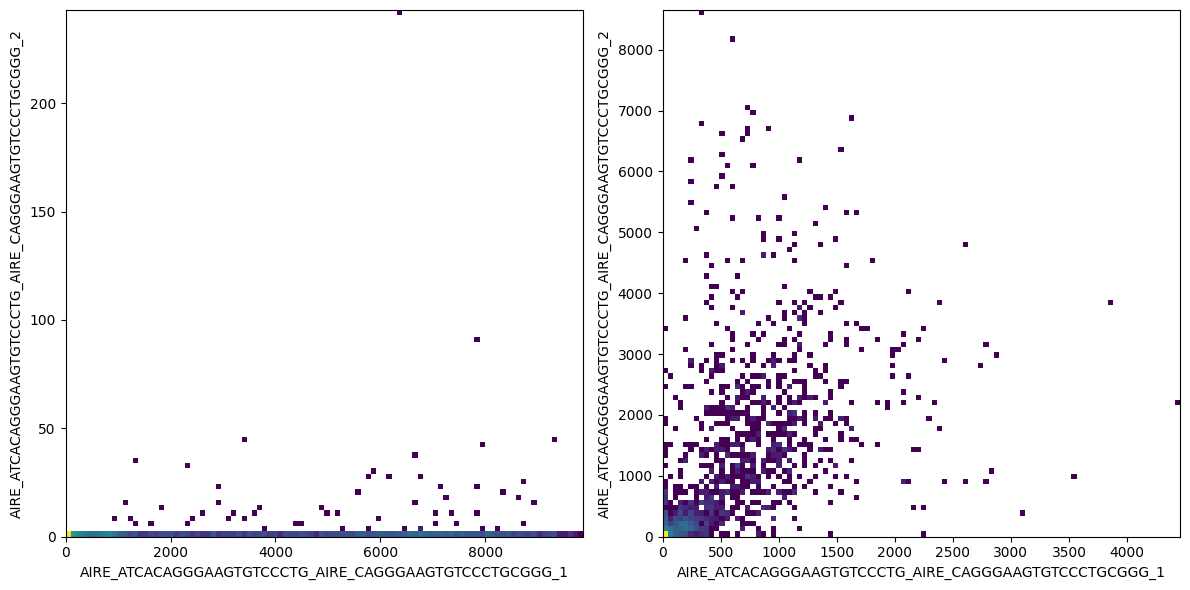

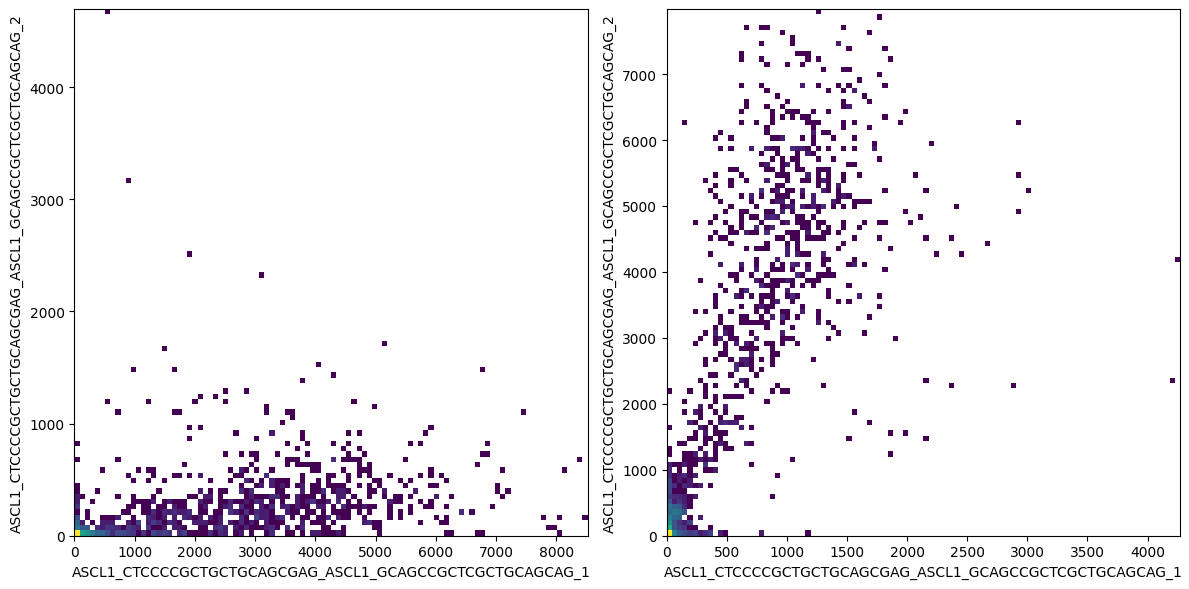

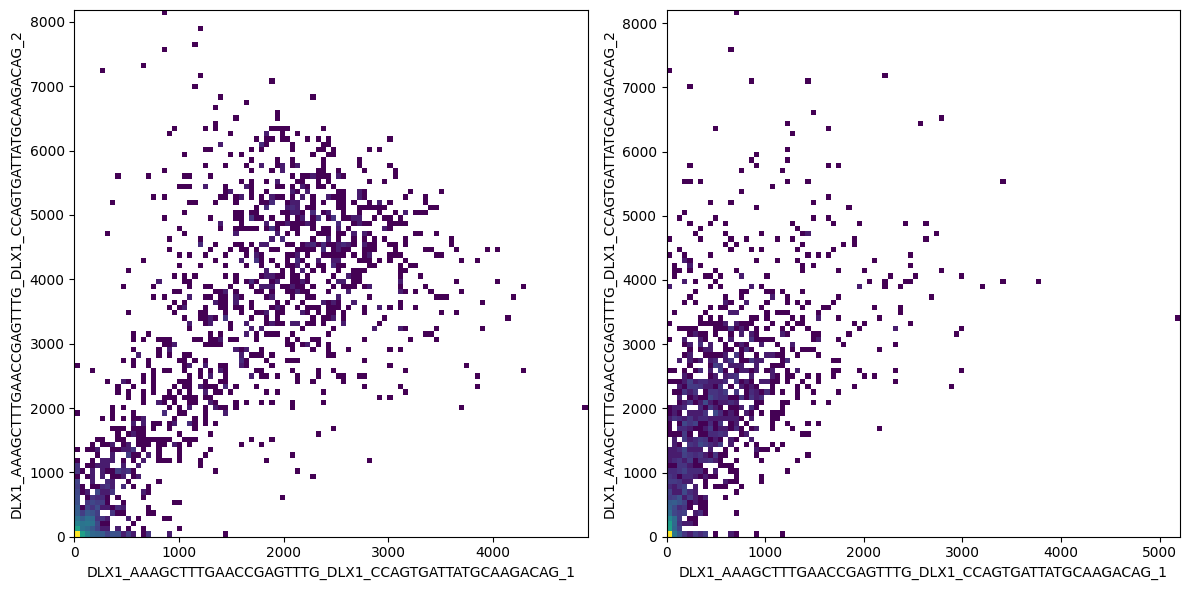

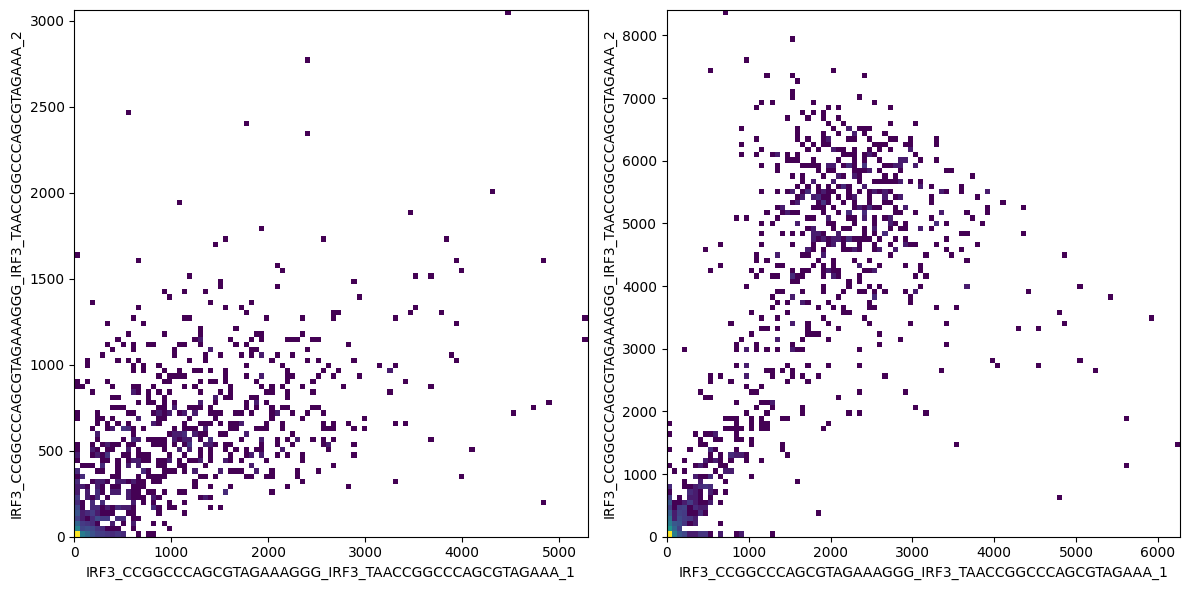

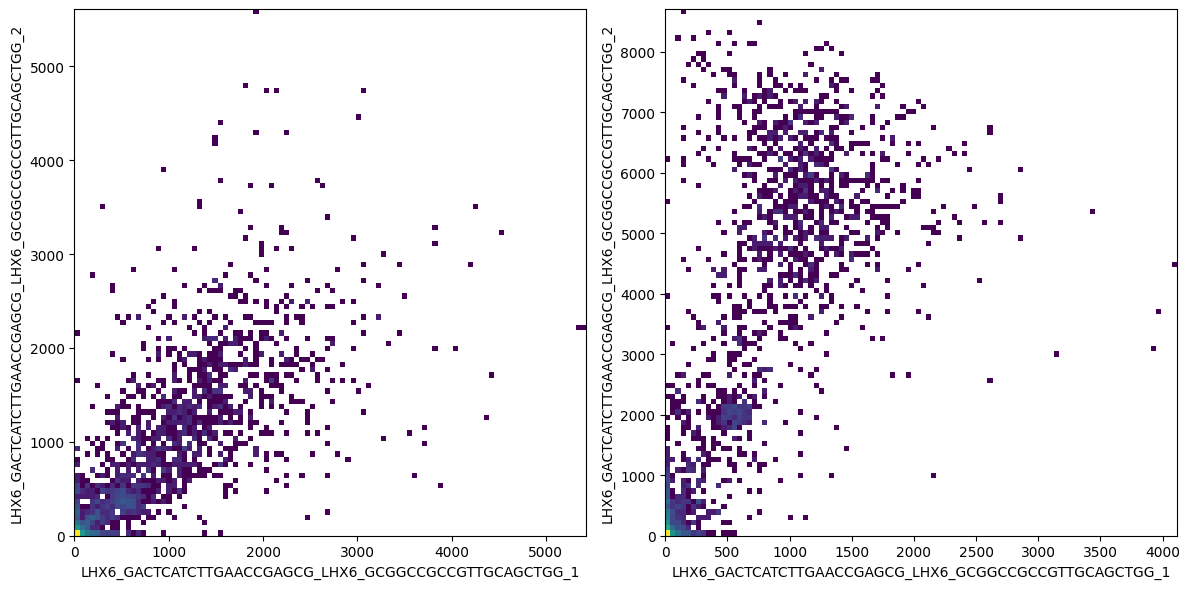

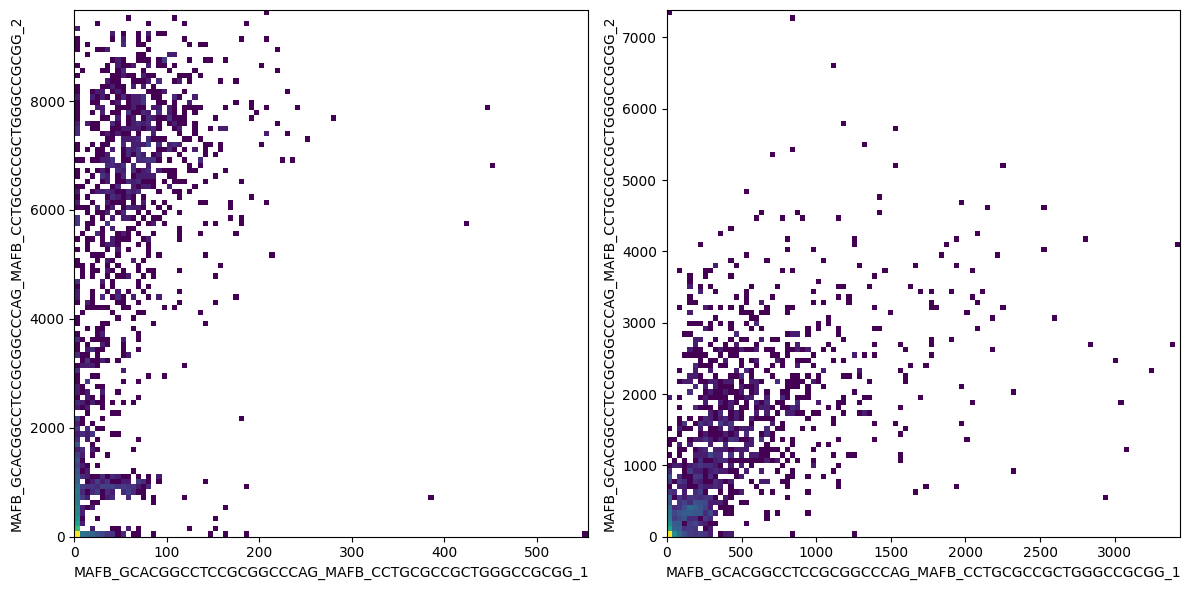

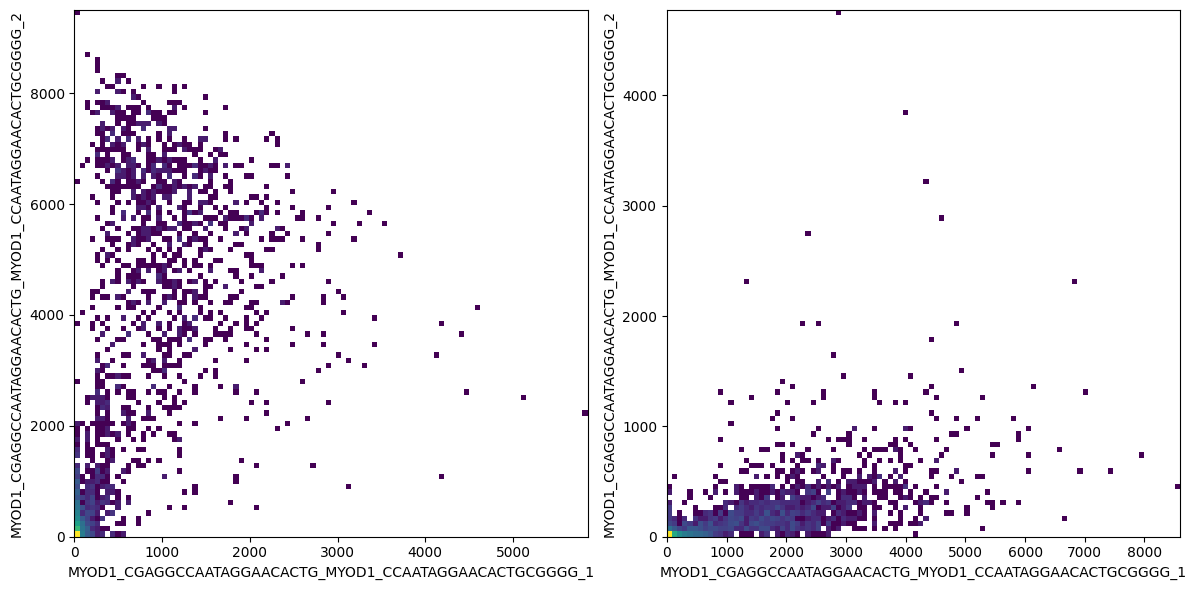

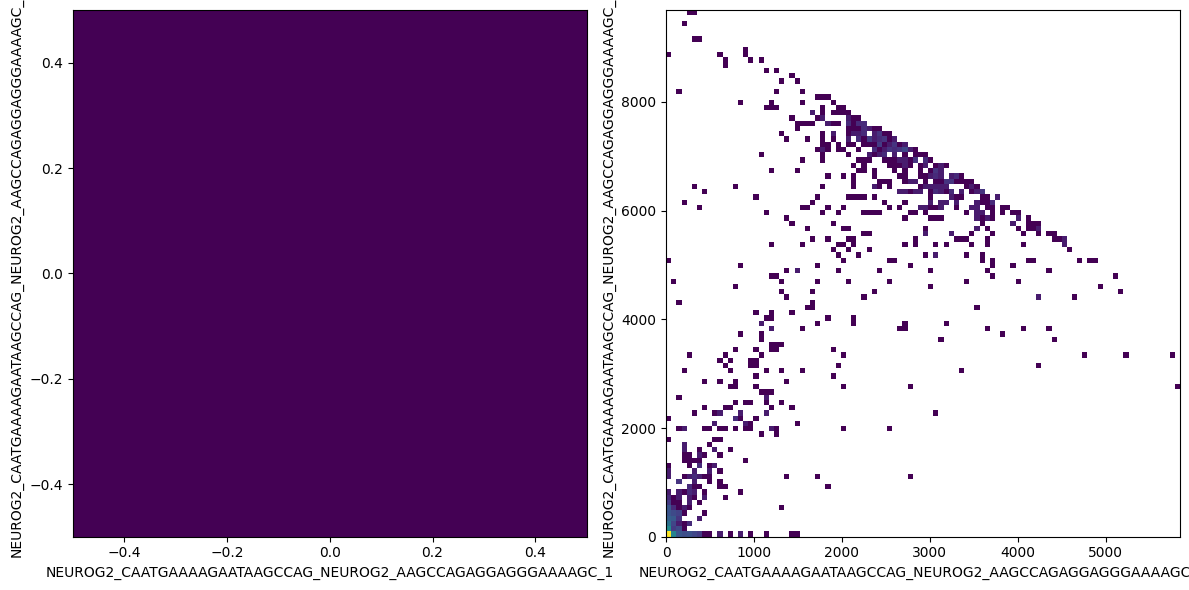

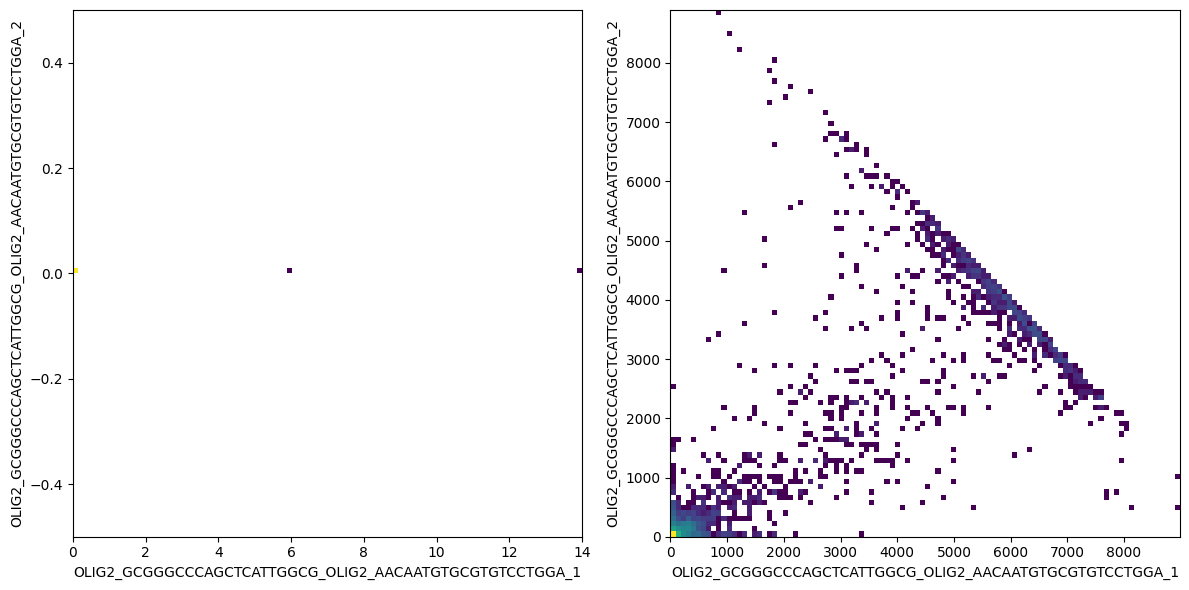

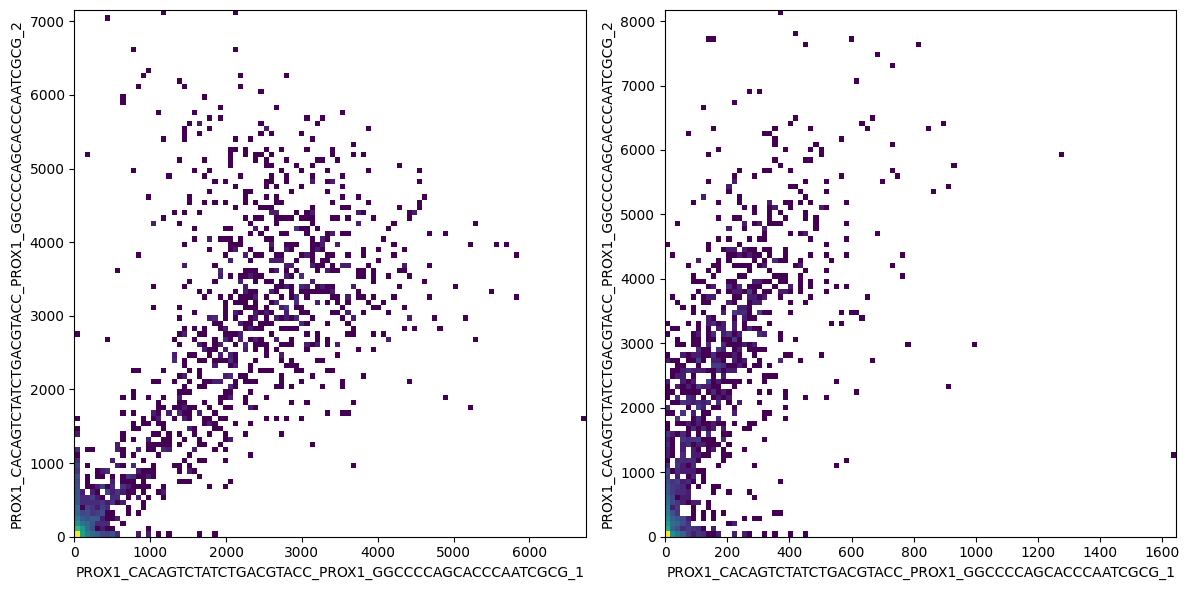

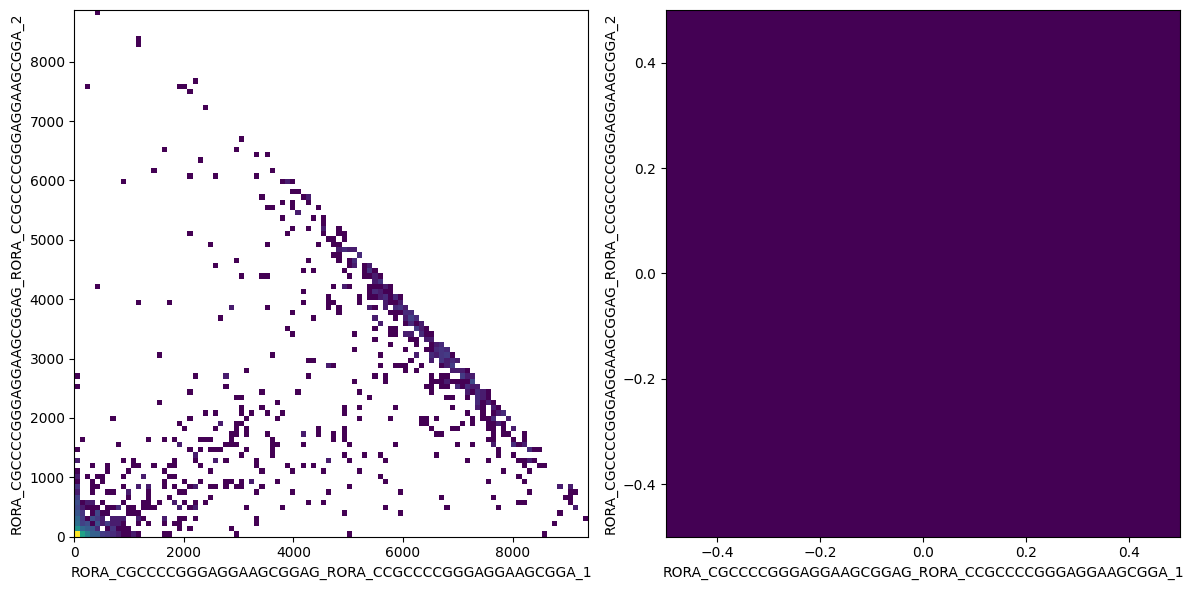

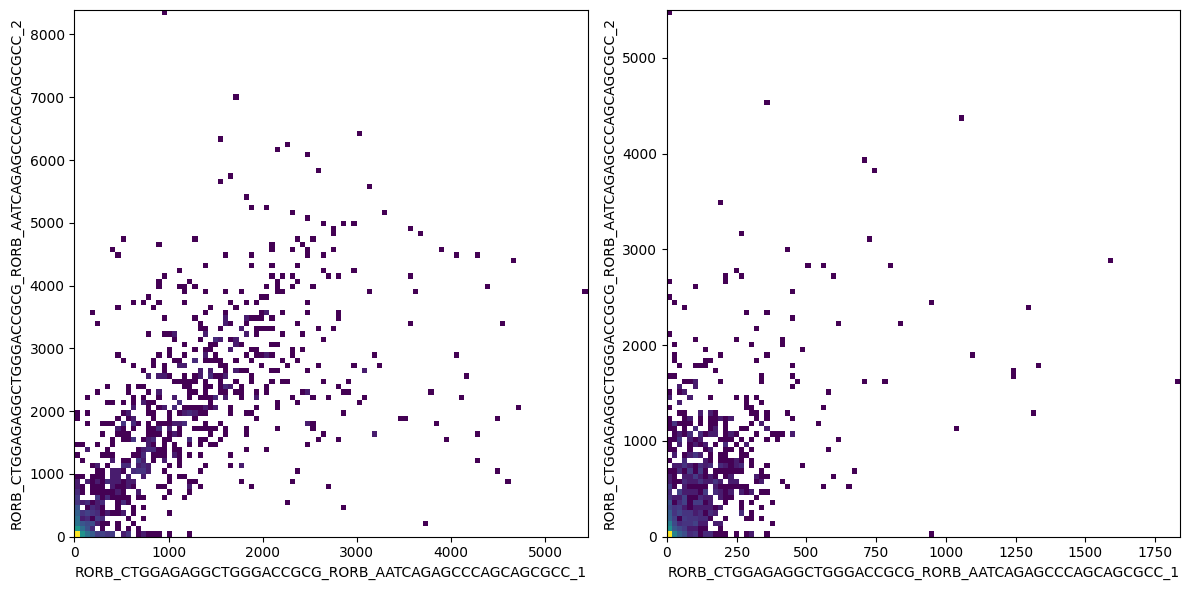

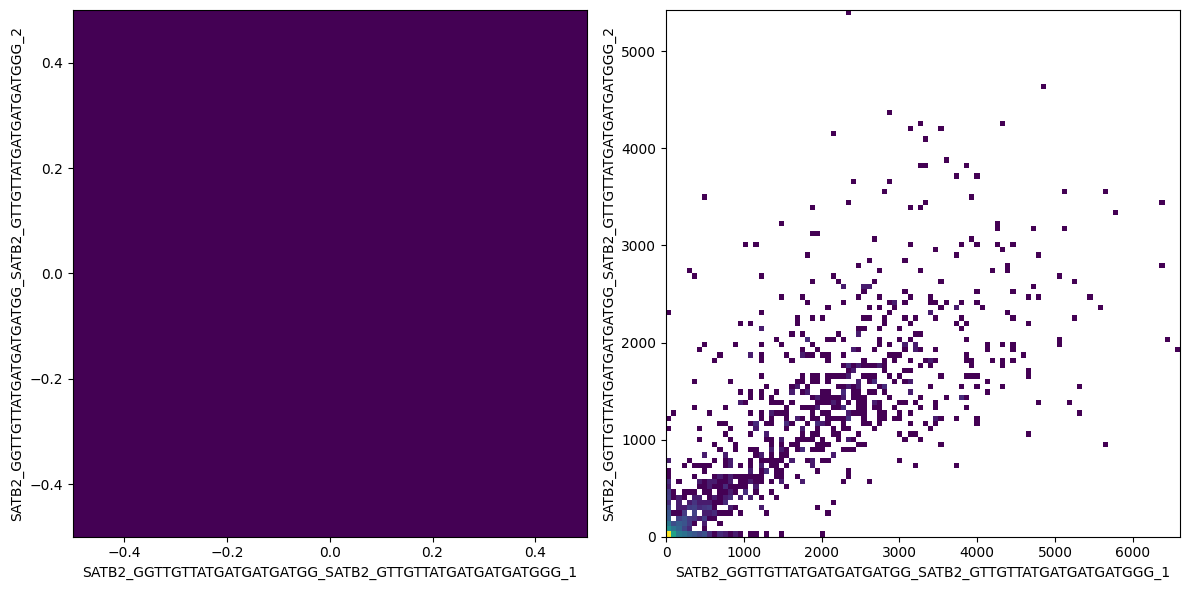

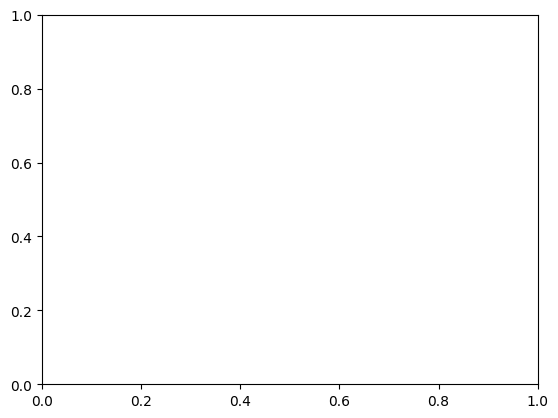

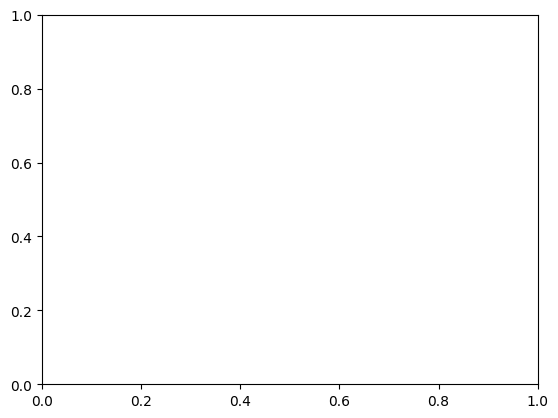

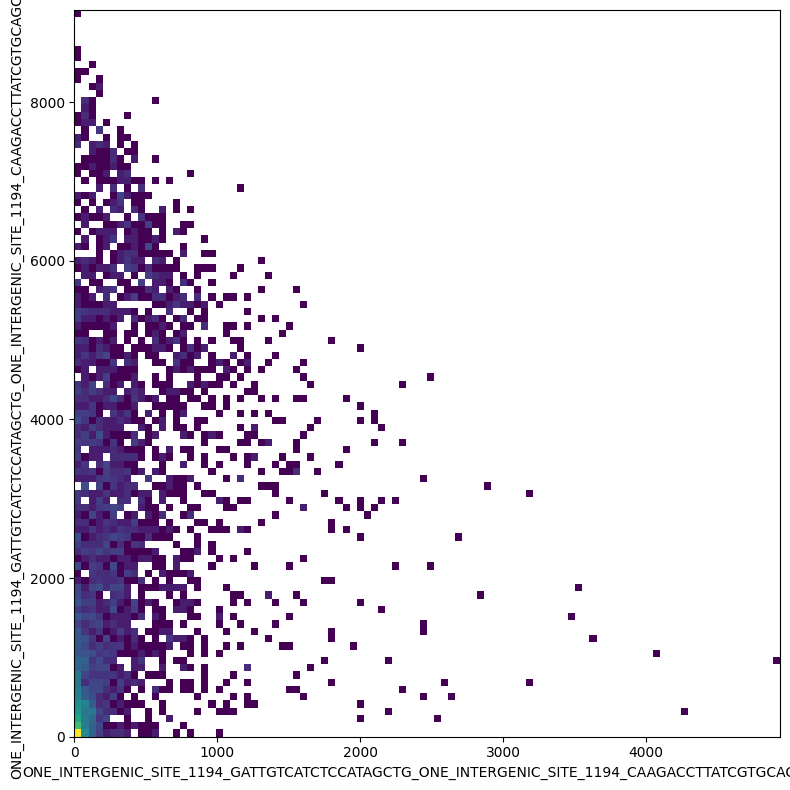

In [45]:
#extract unique guide names from adata.var_names without _1 or _2 extension
guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for short_name in expected_guides:
    tmp_guides = guides[guides.str.contains(short_name)]
    fig,axs = plt.subplots(1,len(tmp_guides))

    for i,guide_name in enumerate(tmp_guides):
        print(i)
        
        hist2d = adata_filtered[:,adata_filtered.var_names.str.contains(guide_name)]
        hist2d=sparse_to_2d_arr(hist2d)
        
        if hist2d.shape[1] == 2:
            #needs to be plotted differently for single subplot and multiple subplots
            if len(tmp_guides) == 2:
                #multiple subplots
                axs[i].hist2d(hist2d[:,0],hist2d[:,1],bins=100,density=True, 
                    norm = colors.LogNorm())
                #add x and y label
                for ax in axs.flat:
                    ax.set(xlabel=f'{guide_name}_1', ylabel=f'{guide_name}_2')
                fig.set_figheight(6)
                fig.set_figwidth(12)


            else:
                #single subplot
                axs.hist2d(hist2d[:,0],hist2d[:,1],bins=100,density=True, 
                    norm = colors.LogNorm())
                plt.xlabel(f'{guide_name}_1')
                plt.ylabel(f'{guide_name}_2')
                fig.set_figheight(8)
                fig.set_figwidth(8)



            #plot tigh bbox
            plt.tight_layout()


<h3> 2. Data exploration of filtered data </h3>

In [ ]:
adata_preprocessed = sc.read_h5ad(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230116_adata_pre_processed.h5ad')

In [ ]:
# Leiden clustering with resolution 2
sc.tl.leiden(adata_preprocessed, resolution=2)
# Plot UMAP
sc.pl.umap(adata_preprocessed, color=['leiden'],
           color_map = 'RdPu', ncols = 3, #legend_loc='on data',
           size=5,
           legend_fontsize=10,
           frameon=False,
           show=False
           )
plt.savefig(f'{figures_folder}{today}_leiden_res_2.pdf')

In [ ]:
ipsc_tf = ['SOX2', 'KLF4', 'POU5F1', 'NANOG']
cell_cycle = ['MKI67', 'PCNA']
targeted_tf_guides, targeted_tf, ipsc_tf, cell_cycle

In [ ]:
expected_tfs = [
'AIRE',
'ASCL1',
'DBX2',
'DLX1',
'DLX5',
'FOXN1',
'GATA2',
'IRF3',
'LHX6',
'MAFB',
'MYOD1',
'NEUROD2',
'NEUROG2',
'OLIG1',
'OLIG2',
'PROX1',
'RORA',
'RORB',
'SATB2',
]

[i for i in expected_tfs if i not in targeted_tf]

In [ ]:
len(np.unique(targeted_tf)), len(expected_tfs)

In [ ]:
adata_preprocessed

In [ ]:
sc.pl.dotplot(adata_preprocessed, targeted_tf_guides, 
              standard_scale='var',
              groupby='leiden', color_map = 'RdPu', gene_symbols='SYMBOL')

sc.pl.umap(adata_preprocessed, color=targeted_tf_guides,
           color_map='RdPu', ncols=4, #legend_loc='on data',
           vmin=0, vmax='p99.999', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL')

In [ ]:
#compare to clean ipsc data 